In [21]:
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import helper_functions as hp
import pandas as pd
import cv2
import matplotlib as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
#from keras import backend as K

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [23]:
import tensorflow as tf
tf.test.gpu_device_name()
tf.test.is_gpu_available()
tf.device('/gpu:1')

2022-12-07 13:31:47.256843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 9637 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2022-12-07 13:31:47.257081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:1 with 9636 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5
2022-12-07 13:31:47.259136: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 9637 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2022-12-07 13:31:47.259350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:1 with 9636 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


## Load in planetscope dataset and create a simple CNN with it.

In [24]:
# Load in planetscope data
#K.clear_session()
planetscope_images_tif, planetscope_labels_tif = hp.dataset_reader_planetscope('planetscope_chips_90m_3class_classified_tiles')

reading in 30466 images


In [25]:
np.unique(planetscope_labels_tif, axis=0, return_counts=True)

(array([1, 2, 3], dtype=uint16), array([ 6236,   308, 23922]))

In [26]:
# Shuffle labels and images and create a train test split for planetscope data
train_images, test_images, train_labels, test_labels = train_test_split(planetscope_images_tif, planetscope_labels_tif, test_size=.2, shuffle=True)

In [27]:
print(train_images[0].shape)
print(test_images[0].shape)

(32, 32, 4)
(32, 32, 4)


## Do oversampling and data augmentation on planetscope data

In [28]:
# Map images and labels using pandas dataframe
df_dict = {"images": [], "labels": []}

for i in range(len(train_images)):
    df_dict["images"].append(train_images[i])
    df_dict["labels"].append(train_labels[i])

df = pd.DataFrame(data=df_dict)

label_1_rows = df.loc[df['labels'] == 1]
label_2_rows = df.loc[df['labels'] == 2]
label_3_rows = df.loc[df['labels'] == 3]

print(len(label_1_rows))
print(len(label_2_rows))
print(len(label_3_rows))

4968
249
19155


In [29]:
# Oversample and data augment images from labels 1 and 2 for planetscope
new_L1_df = hp.augment_label_1(label_1_rows)
print("New label 1 images:", len(new_L1_df))

new_L2_df = hp.augment_label_2(label_2_rows)
print("New label 2 images", len(new_L2_df))

L1_L2 = pd.concat([new_L1_df, new_L2_df], ignore_index=True)
new_df = pd.concat([L1_L2, label_3_rows], ignore_index=True)

New label 1 images: 19872
New label 2 images 19920


In [30]:
# Get new planetscope images and labels from new dataframe
comb_planetscope_images = []
comb_naip_labels = []

for index, row in new_df.iterrows():
    new_image = row["images"]
    new_label = row["labels"]

    comb_planetscope_images.append(new_image)
    comb_naip_labels.append(new_label)

comb_planetscope_images = np.asarray(comb_planetscope_images)
comb_naip_labels = np.asarray(comb_naip_labels)

In [31]:
# Encode planetscope data
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(comb_naip_labels.reshape(-1, 1))
planetscope_new_labels = enc.transform(comb_naip_labels.reshape(-1, 1)).toarray().astype('uint8')

print(comb_naip_labels[0])
print(comb_naip_labels.shape)

1
(58947,)


In [32]:
# Do a train_test_split with oversampled and augmented data for planetscope
train_images, test_images, train_labels, test_labels = train_test_split(comb_planetscope_images, planetscope_new_labels, test_size=.2, shuffle=True)

In [33]:
np.unique(train_labels, axis=0, return_counts=True)

(array([[0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]], dtype=uint8),
 array([15340, 15931, 15886]))

In [34]:
# Create a simple model for the planetscope data 
model = hp.get_simple_model(train_images[0].shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 50)        5050      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 50)       200       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 50)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 30)        37530     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 30)      

In [35]:
# Calculate initial test accuracy for planetscope data.
test_init = hp.get_test_accuracy(model, test_images, test_labels)
train_init = hp.get_train_accuracy(model, train_images, train_labels)

accuracy: 0.324
accuracy: 0.326


In [36]:
# Train model with planetscope data
history = model.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels))

Epoch 1/30
1474/1474 [==============================] - 15s 10ms/step - loss: 0.2881 - accuracy: 0.8946 - val_loss: 0.7964 - val_accuracy: 0.6980
Epoch 2/30
1474/1474 [==============================] - 14s 10ms/step - loss: 0.2401 - accuracy: 0.9123 - val_loss: 0.4553 - val_accuracy: 0.8195
Epoch 3/30
1474/1474 [==============================] - 14s 10ms/step - loss: 0.2165 - accuracy: 0.9220 - val_loss: 0.4332 - val_accuracy: 0.8701
Epoch 4/30
1474/1474 [==============================] - 14s 10ms/step - loss: 0.1849 - accuracy: 0.9346 - val_loss: 0.7774 - val_accuracy: 0.7395
Epoch 5/30
1474/1474 [==============================] - 14s 10ms/step - loss: 0.1598 - accuracy: 0.9451 - val_loss: 0.7185 - val_accuracy: 0.8071
Epoch 6/30
1474/1474 [==============================] - 14s 10ms/step - loss: 0.1339 - accuracy: 0.9560 - val_loss: 0.5645 - val_accuracy: 0.7969
Epoch 7/30
1474/1474 [==============================] - 14s 10ms/step - loss: 0.1124 - accuracy: 0.9635 - val_loss: 0.2708 -

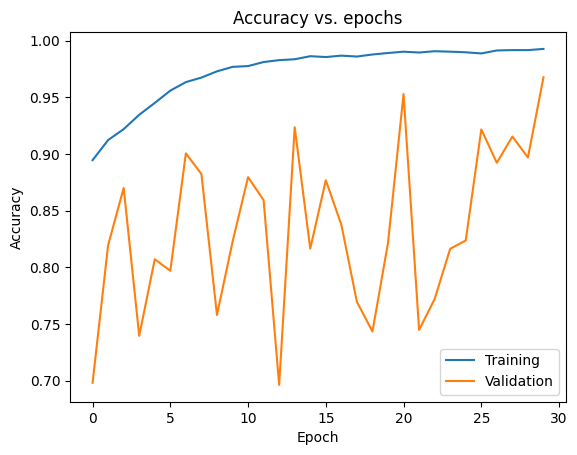

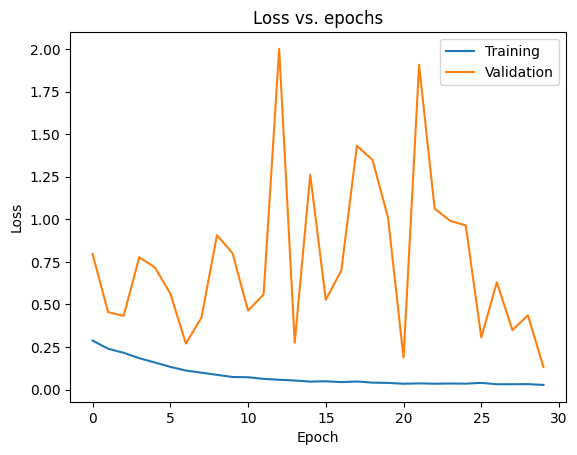

In [37]:
# Plot accuracy for planetscope data
hp.plot_accuracy(history)
hp.plot_loss(history)

In [38]:
# Get accuracy after training the planetscope model once
test_first = hp.get_test_accuracy(model, test_images, test_labels)
train_first = hp.get_train_accuracy(model, train_images, train_labels)

accuracy: 0.968
accuracy: 0.980


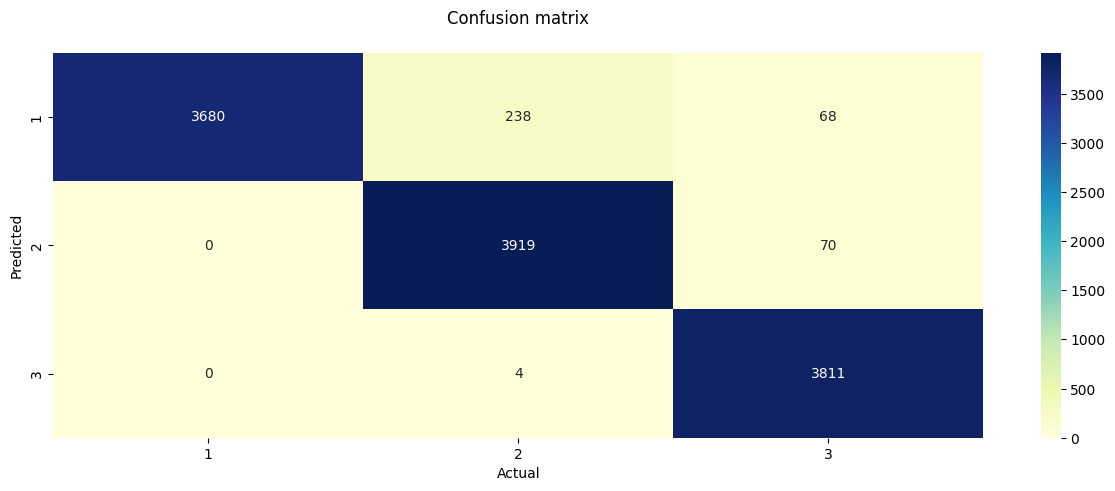

In [39]:
# Plot confusion matrix for planetscope data here
hp.conf_mat(model, test_images, test_labels)

## Make TL model for planetscope data here

In [14]:
img = train_images[0]
img = img[:,:,:3]
print(img.shape)
tl_model = hp.get_TL_model(img.shape)
tl_model.summary()

(32, 32, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 23,719,043
Trainable params: 131,331
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
test_images = test_images[:,:,:,0:3]
train_images = train_images[:,:,:,0:3]

print(test_images[0].shape)
print(train_images[0].shape)

(32, 32, 3)
(32, 32, 3)


In [16]:
# Calculate initial test accuracy for planetscope data with TL model
test_init = hp.get_test_accuracy(tl_model, test_images, test_labels)
train_init = hp.get_train_accuracy(tl_model, train_images, train_labels)

2022-12-07 12:58:31.645258: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


accuracy: 0.423
accuracy: 0.427


In [17]:
# Train TL model with planetscope data
history = tl_model.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels))

Epoch 1/30
1484/1484 [==============================] - 33s 21ms/step - loss: 0.8559 - accuracy: 0.6176 - val_loss: 0.6522 - val_accuracy: 0.7208
Epoch 2/30
1484/1484 [==============================] - 31s 21ms/step - loss: 0.7217 - accuracy: 0.6758 - val_loss: 0.6043 - val_accuracy: 0.7290
Epoch 3/30
1484/1484 [==============================] - 31s 21ms/step - loss: 0.6935 - accuracy: 0.6912 - val_loss: 0.5876 - val_accuracy: 0.7381
Epoch 4/30
1484/1484 [==============================] - 30s 21ms/step - loss: 0.6689 - accuracy: 0.7060 - val_loss: 0.5641 - val_accuracy: 0.7539
Epoch 5/30
1484/1484 [==============================] - 31s 21ms/step - loss: 0.6610 - accuracy: 0.7123 - val_loss: 0.5570 - val_accuracy: 0.7538
Epoch 6/30
1484/1484 [==============================] - 31s 21ms/step - loss: 0.6434 - accuracy: 0.7184 - val_loss: 0.5291 - val_accuracy: 0.7702
Epoch 7/30
1484/1484 [==============================] - 30s 21ms/step - loss: 0.6314 - accuracy: 0.7242 - val_loss: 0.5556 -

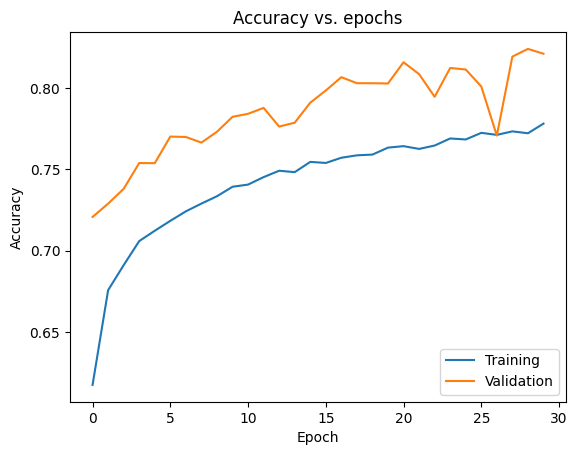

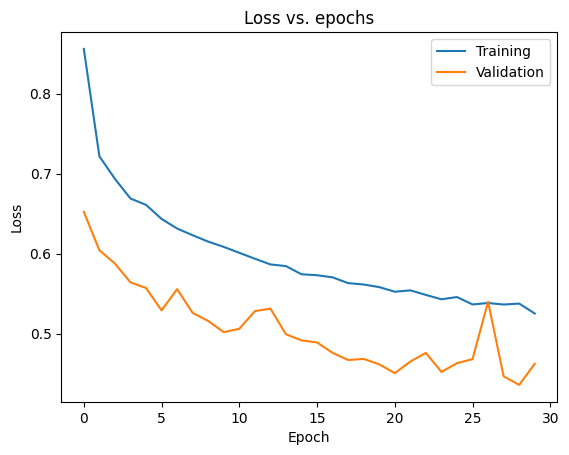

In [18]:
# Plot accuracy for planetscope data with TL model
hp.plot_accuracy(history)
hp.plot_loss(history)

In [19]:
# Get accuracy after training the planetscope model once with TL model
test_first = hp.get_test_accuracy(tl_model, test_images, test_labels)
train_first = hp.get_train_accuracy(tl_model, train_images, train_labels)

accuracy: 0.821
accuracy: 0.829


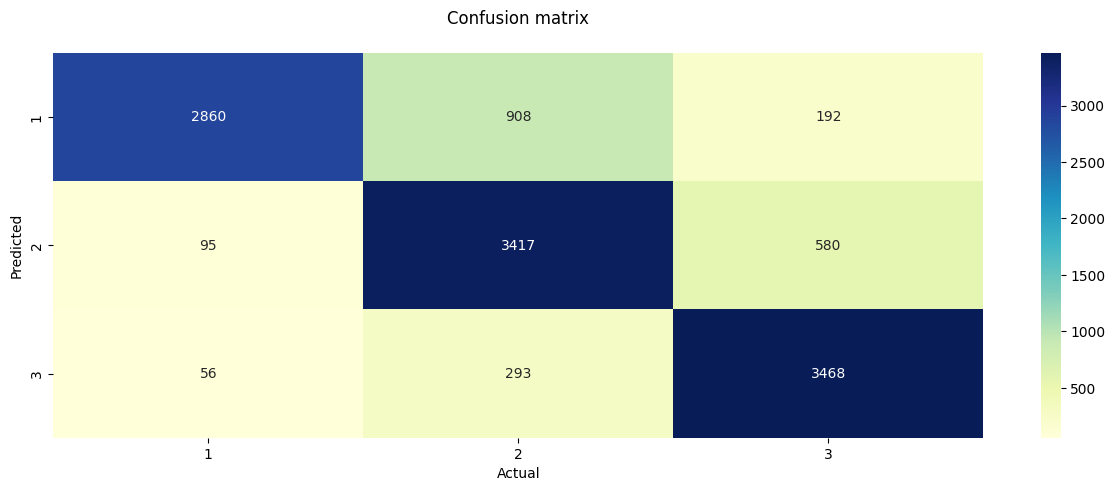

In [20]:
# Plot confusion matrix for planetscope data here
hp.conf_mat(tl_model, test_images, test_labels)

## Load in the naip data and create a simple CNN with it.

In [40]:
naip_images_tif, naip_labels_tif = hp.dataset_reader_naip('naip_2018_chips_90m_3class_classified_tiles')

reading in 30444 images
read in 30441 valid images and labels


In [41]:
np.unique(naip_labels_tif, axis=0, return_counts=True)

(array([1, 2, 3], dtype=uint16), array([ 6204,   319, 23918]))

In [42]:
# Shuffle labels and images and create a train test split for NAIP data
train_images, test_images, train_labels, test_labels = train_test_split(naip_images_tif, naip_labels_tif, test_size=.2, shuffle=True)

## Do oversampling and data augmentation for NAIP data

In [43]:
# Map images and labels using pandas dataframe
df_dict = {"images": [], "labels": []}

for i in range(len(train_images)):
    df_dict["images"].append(train_images[i])
    df_dict["labels"].append(train_labels[i])

df = pd.DataFrame(data=df_dict)

label_1_rows = df.loc[df['labels'] == 1]
label_2_rows = df.loc[df['labels'] == 2]
label_3_rows = df.loc[df['labels'] == 3]

print(len(label_1_rows))
print(len(label_2_rows))
print(len(label_3_rows))

5011
262
19079


In [44]:
# Oversample and data augment images from labels 1 and 2 for naip
new_L1_df = hp.augment_label_1(label_1_rows)
print("New label 1 images:", len(new_L1_df))

new_L2_df = hp.augment_label_2(label_2_rows)
print("New label 2 images", len(new_L2_df))

L1_L2 = pd.concat([new_L1_df, new_L2_df], ignore_index=True)
new_df = pd.concat([L1_L2, label_3_rows], ignore_index=True)

L1_L2 = pd.concat([new_L1_df, new_L2_df], ignore_index=True)
new_df = pd.concat([L1_L2, label_3_rows], ignore_index=True)

New label 1 images: 20044
New label 2 images 20960


In [45]:
# Get new naip images and labels from new dataframe
comb_naip_images = []
comb_naip_labels = []

for index, row in new_df.iterrows():
    new_image = row["images"]
    new_label = row["labels"]

    comb_naip_images.append(new_image)
    comb_naip_labels.append(new_label)

comb_naip_images = np.asarray(comb_naip_images)
comb_naip_labels = np.asarray(comb_naip_labels)

In [46]:
# Encode naip data
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(comb_naip_labels.reshape(-1, 1))
naip_new_labels = enc.transform(comb_naip_labels.reshape(-1, 1)).toarray().astype('uint8')

print(comb_naip_labels[0])
print(comb_naip_labels.shape)

1
(60083,)


In [47]:
# Do a train_test_split with oversampled and augmented data for naip
train_images, test_images, train_labels, test_labels = train_test_split(comb_naip_images, naip_new_labels, test_size=.2, shuffle=True)

In [48]:
np.unique(train_labels, axis=0, return_counts=True)

(array([[0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]], dtype=uint8),
 array([15217, 16756, 16093]))

In [49]:
# Create a simple model for the NAIP data 
model = hp.get_simple_model(train_images[0].shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 90, 90, 50)        5050      
                                                                 
 batch_normalization_4 (Batc  (None, 90, 90, 50)       200       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 50)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 45, 45, 50)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 30)        37530     
                                                                 
 batch_normalization_5 (Batc  (None, 45, 45, 30)      

In [50]:
# Calculate initial test accuracy for NAIP data
test_init = hp.get_test_accuracy(model, test_images, test_labels)
train_init = hp.get_train_accuracy(model, train_images, train_labels)

accuracy: 0.278
accuracy: 0.285


In [51]:
# Train model with NAIP data
history = model.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels))

Epoch 1/30
1503/1503 [==============================] - 20s 13ms/step - loss: 0.2145 - accuracy: 0.9233 - val_loss: 0.3200 - val_accuracy: 0.8642
Epoch 2/30
1503/1503 [==============================] - 19s 13ms/step - loss: 0.1005 - accuracy: 0.9686 - val_loss: 0.7291 - val_accuracy: 0.9029
Epoch 3/30
1503/1503 [==============================] - 19s 13ms/step - loss: 0.0660 - accuracy: 0.9812 - val_loss: 3.8688 - val_accuracy: 0.9117
Epoch 4/30
1503/1503 [==============================] - 19s 13ms/step - loss: 0.0472 - accuracy: 0.9879 - val_loss: 0.2359 - val_accuracy: 0.9527
Epoch 5/30
1503/1503 [==============================] - 19s 13ms/step - loss: 0.0359 - accuracy: 0.9914 - val_loss: 0.4840 - val_accuracy: 0.9598
Epoch 6/30
1503/1503 [==============================] - 19s 13ms/step - loss: 0.0306 - accuracy: 0.9932 - val_loss: 1.1498 - val_accuracy: 0.8485
Epoch 7/30
1503/1503 [==============================] - 19s 13ms/step - loss: 0.0288 - accuracy: 0.9937 - val_loss: 0.3206 -

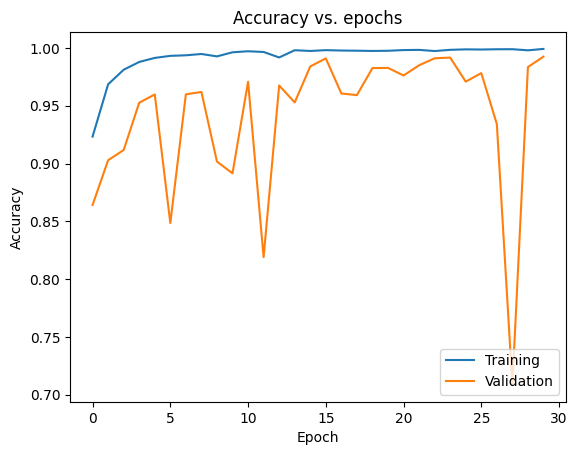

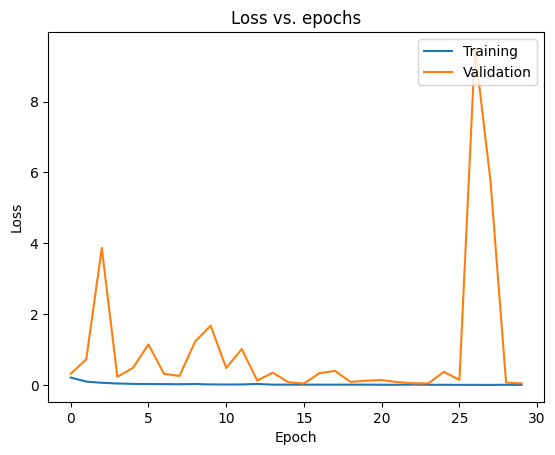

In [52]:
# Plot accuracy for NAIP data
hp.plot_accuracy(history)
hp.plot_loss(history)

In [53]:
# Get accuracy after training the NAIP model once
test_first = hp.get_test_accuracy(model, test_images, test_labels)
train_first = hp.get_train_accuracy(model, train_images, train_labels)

accuracy: 0.993
accuracy: 1.000


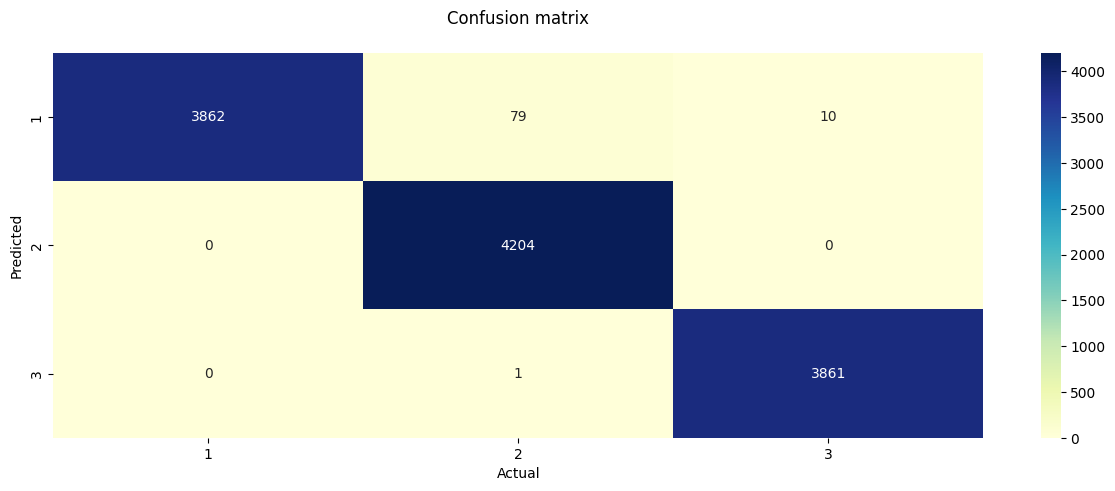

In [54]:
# Plot confusion matrix for naip data here
hp.conf_mat(model, test_images, test_labels)

## Make TL model for NAIP Data Here

In [59]:
img = train_images[0]
img = img[:,:,:3]
print(img.shape)
tl_model = hp.get_TL_model(img.shape)
tl_model.summary()

(90, 90, 3)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_12 (Dense)            (None, 64)                131136    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 3)                 195       
                                                                 
Total params: 23,719,043
Trainable params: 131,331
Non-trainable params: 23,587,712
_________________________________________________________________


In [52]:
test_images = test_images[:,:,:,0:3]
train_images = train_images[:,:,:,0:3]

print(test_images[0].shape)
print(train_images[0].shape)

(90, 90, 3)
(90, 90, 3)


In [60]:
# Calculate initial test accuracy for NAIP data with tl_model
test_init = hp.get_test_accuracy(tl_model, test_images, test_labels)
train_init = hp.get_train_accuracy(tl_model, train_images, train_labels)

accuracy: 0.291
accuracy: 0.291


In [61]:
# Train TL model with NAIP data
history = tl_model.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels))

Epoch 1/30
1481/1481 [==============================] - 35s 23ms/step - loss: 0.3341 - accuracy: 0.8621 - val_loss: 0.2312 - val_accuracy: 0.9002
Epoch 2/30
1481/1481 [==============================] - 33s 22ms/step - loss: 0.2282 - accuracy: 0.9090 - val_loss: 0.1721 - val_accuracy: 0.9360
Epoch 3/30
1481/1481 [==============================] - 33s 22ms/step - loss: 0.1910 - accuracy: 0.9253 - val_loss: 0.1390 - val_accuracy: 0.9489
Epoch 4/30
1481/1481 [==============================] - 33s 22ms/step - loss: 0.1658 - accuracy: 0.9364 - val_loss: 0.1234 - val_accuracy: 0.9543
Epoch 5/30
1481/1481 [==============================] - 33s 22ms/step - loss: 0.1487 - accuracy: 0.9443 - val_loss: 0.1139 - val_accuracy: 0.9590
Epoch 6/30
1481/1481 [==============================] - 33s 22ms/step - loss: 0.1360 - accuracy: 0.9483 - val_loss: 0.1089 - val_accuracy: 0.9658
Epoch 7/30
1481/1481 [==============================] - 33s 22ms/step - loss: 0.1217 - accuracy: 0.9549 - val_loss: 0.0913 -

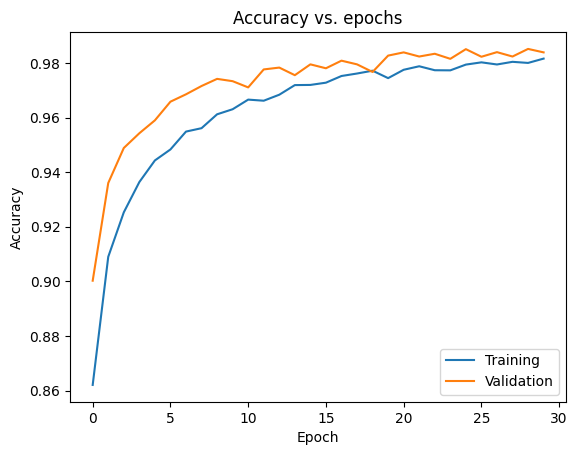

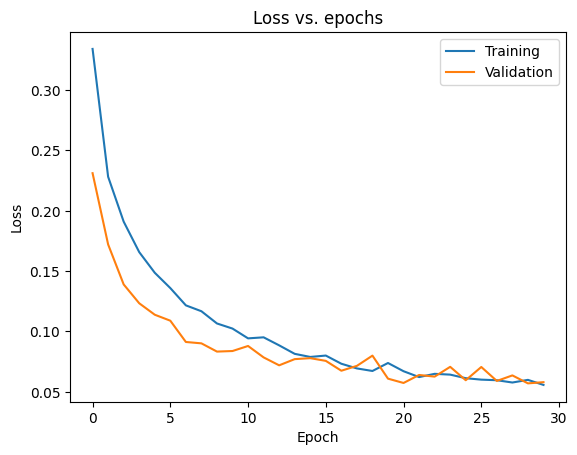

In [62]:
# Plot accuracy for NAIP data with TL model
hp.plot_accuracy(history)
hp.plot_loss(history)

In [65]:
# Get accuracy after training the NAIP model once with TL model
test_first = hp.get_test_accuracy(tl_model, test_images, test_labels)
train_first = hp.get_train_accuracy(tl_model, train_images, train_labels)

accuracy: 0.984
accuracy: 0.995


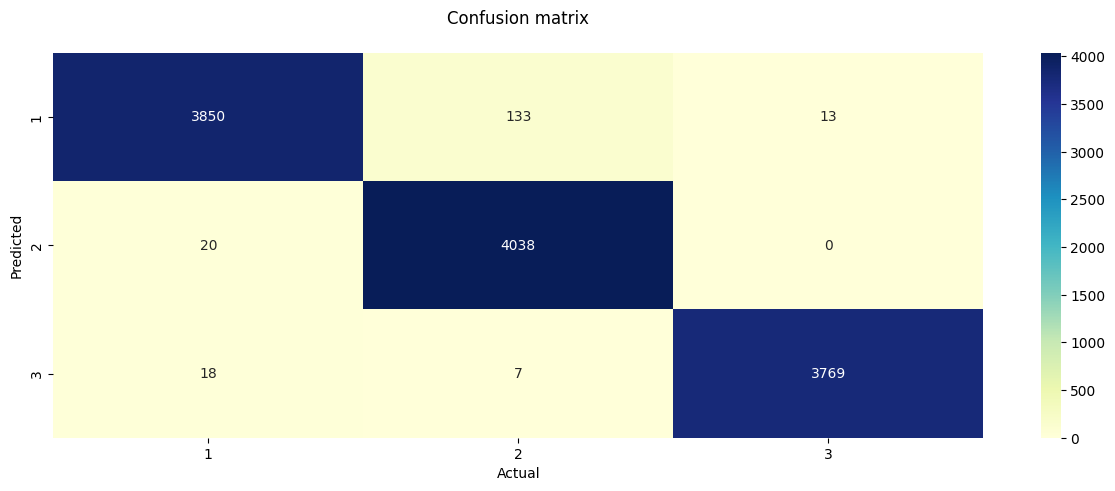

In [64]:
# Plot confusion matrix for naip data here
hp.conf_mat(tl_model, test_images, test_labels)